In [8]:
import sys
#sys.path.append('/opt/ros/melodic/lib/python2.7/dist-packages')
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import rosbag
import rospy
from os import listdir
from os.path import isfile, join

In [10]:
bag_dir = '/home/tim/BT_Tests/pose_estimation'

bag_names = [f for f in listdir(bag_dir) if isfile(join(bag_dir, f))]

bags = []
bag_times = []

for bag_name in bag_names:
    bag = rosbag.Bag(join(bag_dir, bag_name))
    bags.append(bag)
    date_time = bag_name.split(sep='.')[0]
    bag_times.append(date_time)

print(bags)
print(bag_times)

[<rosbag.bag.Bag object at 0x7f1eb63aaf90>, <rosbag.bag.Bag object at 0x7f1ec19fd810>, <rosbag.bag.Bag object at 0x7f1eb664cdd0>, <rosbag.bag.Bag object at 0x7f1eb63aa5d0>, <rosbag.bag.Bag object at 0x7f1f0a245a90>, <rosbag.bag.Bag object at 0x7f1eb66b1e50>]
['2022-07-20-12-10-14', '2022-07-20-12-16-36', '2022-07-20-12-08-01', '2022-07-20-12-14-24', '2022-07-20-12-15-58', '2022-07-20-12-09-05']


In [22]:
palette = sns.color_palette('pastel')
sns.set_style('whitegrid') # darkgrid, whitegrid, dark, white and
plt.rc('lines', linewidth=3)     # linewidth
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('font', size=18)          # controls default text sizes

In [12]:
def cut_list(list, time):
    retList = []
    for i, t in enumerate(time):
        if t < 40.0:
            retList.append(list[i])
        else:
            break
    return retList

# Plot Pose Estimation Results

In [20]:
size = len(bags)
all_position_gt = []
all_time_gt = []
all_position_est = []
all_time_est = []

for i, bag in enumerate(bags):
    stamp_estimate = []
    stamp_gt = []
    position_estimate = []
    position_gt = []
    for topic, msg, t in bag.read_messages('/geranos/visual_servoing/estimated_pole_position'):
        stamp_estimate.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
        position_estimate.append([msg.point.x , msg.point.y, msg.point.z])

    time_estimate = [s-stamp_estimate[0] for s in stamp_estimate]
    position_estimate = cut_list(position_estimate, time_estimate)
    time_estimate = cut_list(time_estimate, time_estimate)

    position_estimate = np.array(position_estimate)

    for topic, msg, t in bag.read_messages('/geranos/geranos_pole_white/vrpn_client/estimated_transform'):
        stamp_gt.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
        position_gt.append([msg.transform.translation.x , msg.transform.translation.y, msg.transform.translation.z])

    time_gt = [s-stamp_gt[0] for s in stamp_gt]
    position_gt = cut_list(position_gt, time_gt)
    time_gt = cut_list(time_gt, time_gt)

    position_gt = np.array(position_gt)

    all_position_gt.append(position_gt)
    all_position_est.append(position_estimate)
    all_time_gt.append(time_gt)
    all_time_est.append(time_estimate)

# Distances

In [31]:
distances = []
for i,bag in enumerate(bags):
    position_uav = []
    for topic, msg, t in bag.read_messages('/geranos/visual_servoing/transformed_odometry'):
        position_uav.append(msg.pose.pose.position.x)
        position_uav.append(msg.pose.pose.position.y)
        break
    position_pole = [all_position_gt[i][0][0], all_position_gt[i][0][1]]
    distance_vec = [position_uav[0] - position_pole[0], position_uav[1] - position_pole[1]]
    distance_vec = np.array(distance_vec)
    distance = np.linalg.norm(distance_vec)
    distances.append(distance)

# Plot Estimation Results

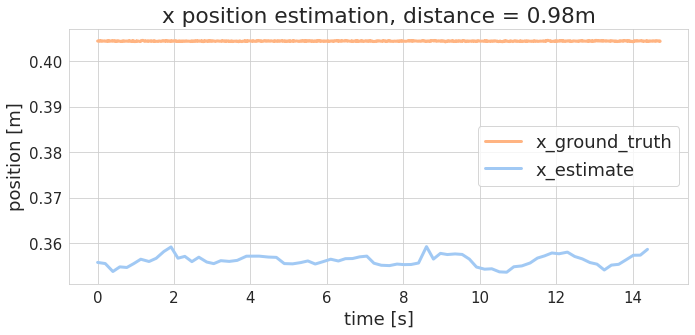

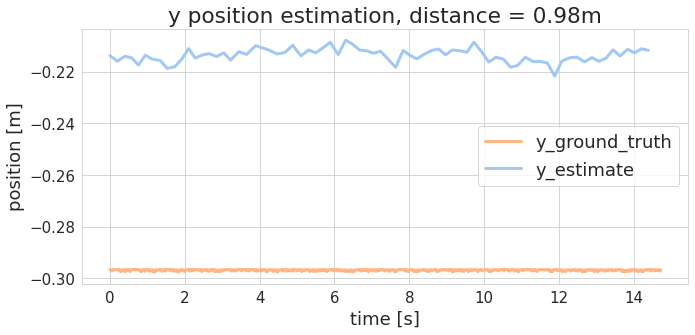

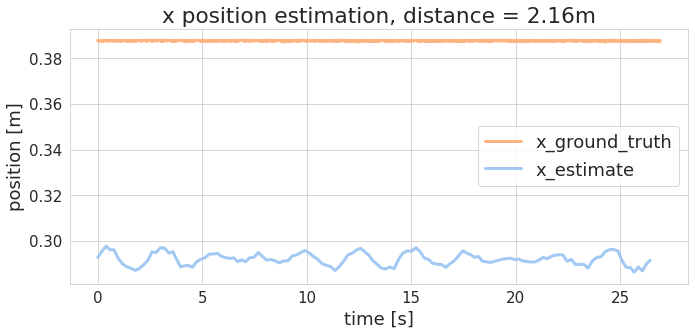

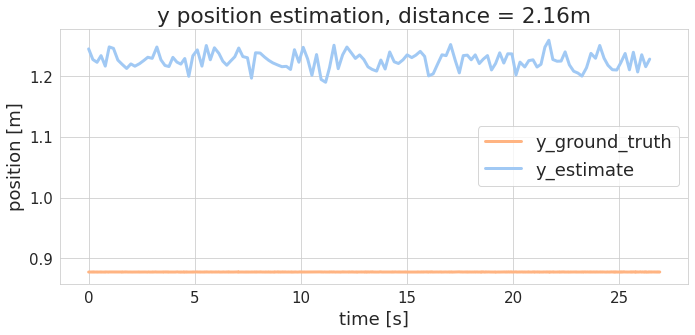

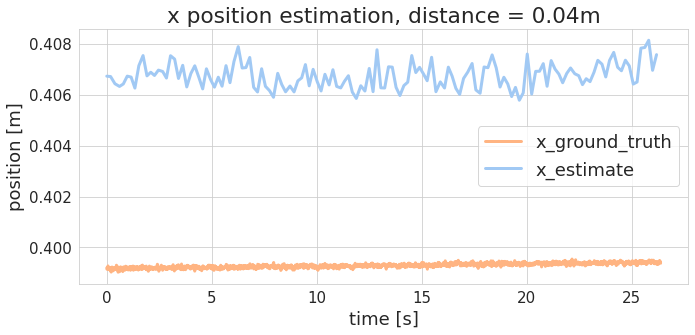

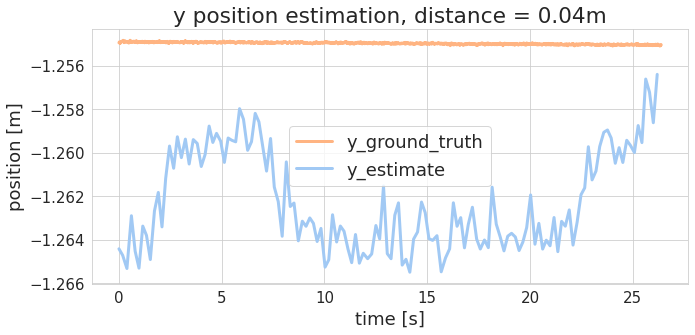

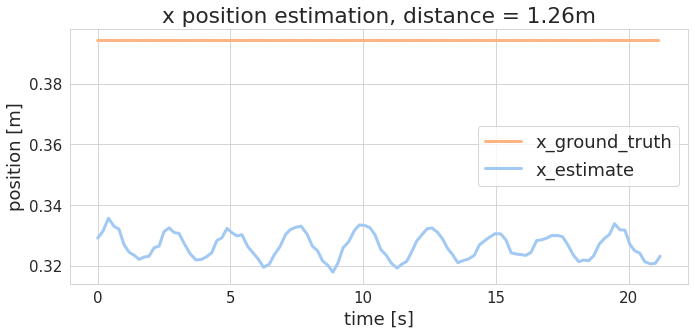

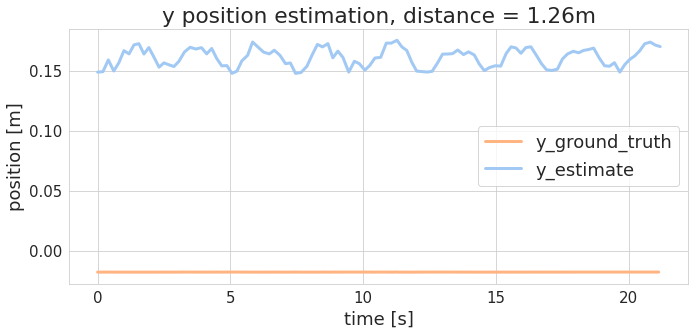

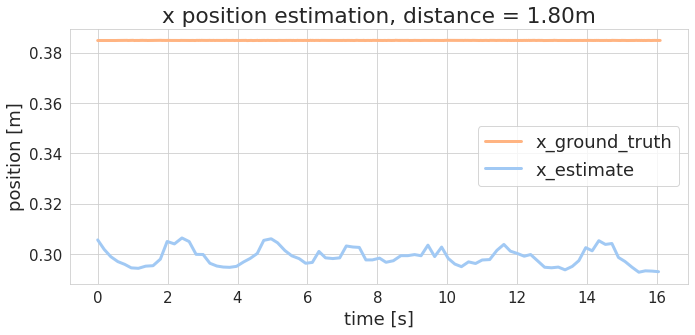

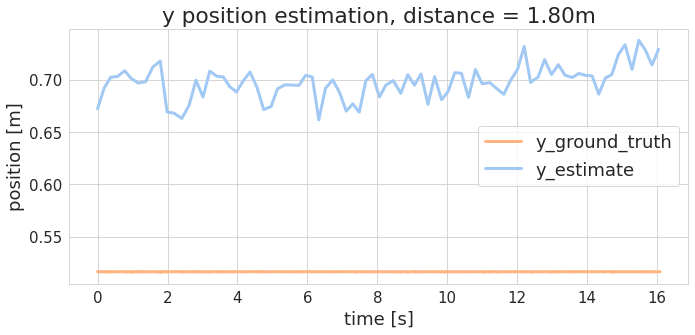

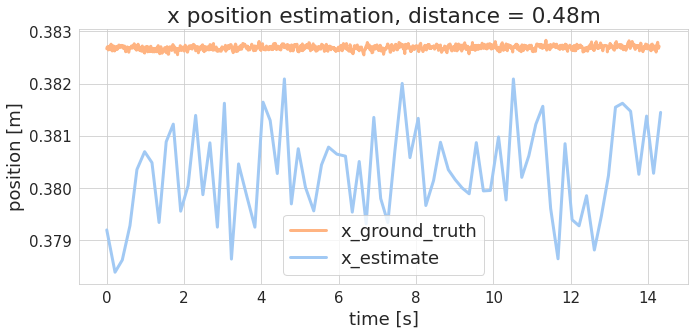

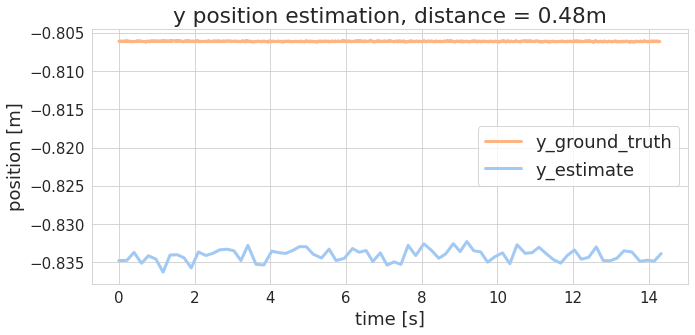

In [35]:
#Visualization
for i in range(len(bags)):
    position_gt = all_position_gt[i]
    position_estimate = all_position_est[i]
    time_gt = all_time_gt[i]
    time_estimate = all_time_est[i]
    date_time = bag_times[i]
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

    ax.set(title='x position estimation, distance = ' + "%.2f" % distances[i] + "m", xlabel='time [s]', ylabel='position [m]')
    ax.plot(time_gt,position_gt[:,0],color = palette[1],label = 'x_ground_truth')
    ax.plot(time_estimate,position_estimate[:,0],color = palette[0],label = 'x_estimate')
    ax.legend()

    plt.savefig('/home/tim/Pictures/pose_est_test_x_'+date_time+'.pdf')

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

    ax.set(title='y position estimation, distance = ' + "%.2f" % distances[i] + "m", xlabel='time [s]', ylabel='position [m]')
    ax.plot(time_gt,position_gt[:,1],color = palette[1],label = 'y_ground_truth')
    ax.plot(time_estimate,position_estimate[:,1],color = palette[0],label = 'y_estimate')
    ax.legend()

    plt.savefig('/home/tim/Pictures/pose_est_test_y_'+date_time+'.pdf')